# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.

Good luck & have fun! :)

In [1]:
# !pip install wandb
# !pip3 install lightning torchmetrics

**✨ Внимание ✨**

В этом домашнем задании предлагается использовать библиотеку `pytorch_lightning`. Доступ к ее [документации](https://lightning.ai/docs/pytorch/stable/) заблокирован с территории РФ. Вы можете:

1. Получить к ней доступ с помощью VPN.

2. Собрать документацию самостоятельно. Для этого склонируйте [github-репозиторий](https://github.com/Lightning-AI/lightning/tree/master), запустите в нем терминал (на windows – git bash) и выполните команды:

```shell
git submodule update --init --recursive
make docs
```
После этого откройте появившийся файл `docs/build/html/index.html`. Для работы команд в вашем окружении должен быть `pip`. Полная инструкция [по ссылке](https://github.com/Lightning-AI/lightning/tree/master/docs).

3. Гуглить `<error message> pytorch lightning` или `<how to do this> pytorch lightning`. Stack overflow на территории РФ все еще доступен 😉

4. Не пользоваться `pytorch_lightning` и написать цикл обучения модели самостоятельно. Например, по аналогии с функцией `fit` из [семинара 4](https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/04.%20Optim%20%26%20Lightning/04_Optim%26Lightning_solution.ipynb).

In [2]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

wandb: Currently logged in as: alekseyshabunya (aleksey_shabunya). Use `wandb login --relogin` to force relogin


True

In [3]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.tuner.tuning import Tuner
from torchvision.models import resnet50
from torchvision.models import efficientnet_v2_s
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping


# You may add any imports you need

In [4]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
# !wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

Посчитаем средние и СКО по каждому каналу

In [7]:
data_loader = DataLoader(ImageFolder('./dataset/dataset/train', transform=transforms.ToTensor()), 
                         batch_size=4096, 
                         shuffle=True, 
                         num_workers=7, 
                         persistent_workers=True)

In [8]:
pixels_sum = torch.tensor([0, 0, 0], requires_grad=False).float()
pixels_square_sum = torch.tensor([0, 0, 0], requires_grad=False).float()
cnt_pixels = torch.tensor(0, requires_grad=False)

for batch in tqdm(data_loader):
    images = batch[0].requires_grad_(requires_grad=False)
    
    pixels_sum += torch.sum(images, dim=(0, 2, 3))
    pixels_square_sum += torch.sum(torch.square(images), dim=(0, 2, 3))
    
    cnt_pixels += images.size()[0] * images.size()[2] * images.size()[3]
    
means = pixels_sum / cnt_pixels
stds = pixels_square_sum / cnt_pixels - torch.square(means)

100%|███████████████████████████████████████████| 25/25 [00:11<00:00,  2.22it/s]


Предобработаем данные

In [9]:
# YOU CAN DEFINE AUGMENTATIONS HERE
train_transform = transforms.Compose(
    [
        transforms.ColorJitter(hue=0.05, saturation=0.05),
        transforms.RandomHorizontalFlip(0.3),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ]
)

val_transform = transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ]
)

train_dataset = ImageFolder('./dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('./dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=7, persistent_workers=True) # YOUR CODE HERE
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=7, persistent_workers=True) # YOUR CODE HERE

In [10]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


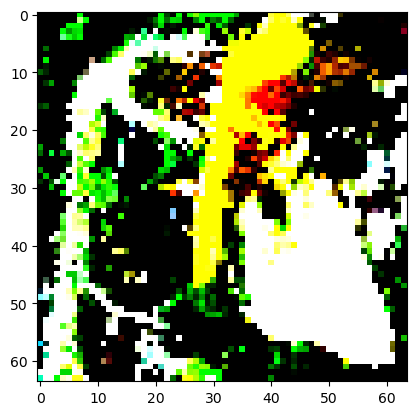

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


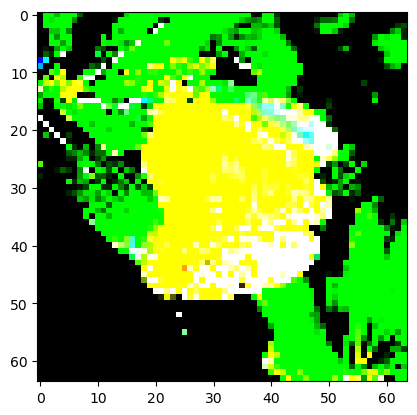

In [11]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1.

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Тренировочный класс lightning

In [12]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=200, top_k=1)
        
    def forward(self, x):
        
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = ReduceLROnPlateau(optimizer, patience=2, threshold=0.1)
        
        return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_accuracy'}}

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        
        preds = self.forward(images)
        
        train_loss = self.loss_func(preds, target)
        train_accuracy = self.accuracy(preds, target)
        
        self.log('train_loss', train_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_accuracy', train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
        return train_loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        
        val_loss = self.loss_func(preds, target)
        val_accuracy = self.accuracy(preds, target)
        
        self.log('val_loss', val_loss, prog_bar=True)
        self.log('val_accuracy', val_accuracy, prog_bar=True)

In [13]:
wandb_logger = WandbLogger(project='HW2 task1', log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning

model = resnet50(weights=None, num_classes=200).to(device) # YOUR CODE HERE
module = YourModule(model, 0.001) # YOUR CODE HERE

In [14]:
checkpoint_callback = ModelCheckpoint(
    dirpath='./models/task1',
    filename='{model}-{epoch}-{val_accuracy:.2f}',
    monitor='val_accuracy',
    save_top_k=1,
    mode='max',
    every_n_epochs=1
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

# early_stopping = EarlyStopping(monitor='train_loss', mode='max', stopping_threshold=0.44)

trainer = pl.Trainer(logger=wandb_logger, 
                     max_epochs=25, 
                     callbacks=[checkpoint_callback, lr_monitor])  # YOUR CODE HERE


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(module, train_dataloader, val_dataloader)  # YOUR CODE HERE
wandb.finish()

/Users/alex/anaconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /Users/alex/Documents/iad-deep-learning/2023/homeworks/hw2/models/task1 exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 23.9 M
1 | loss_func | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
23.9 M    Trainable params
0         Non-trainable params
23.9 M    Total params
95.671    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/alex/anaconda3/lib/python3.11/site-packages/torchmetrics/functional/classification/accuracy.py:77: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  tp = tp.sum(dim=0 if multidim_average == "global" else 1)


Training: |                                               | 0/? [00:00<?, ?it/s]

/Users/alex/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


lr-Adam,▁
trainer/global_step,▁
lr-Adam,0.001
trainer/global_step,0


Я могу обучить 25 эпох реснет50, пока течёт мой любимый кепчук (олды на месте)  
[Ссылка](https://wandb.ai/aleksey_shabunya/HW2%20task1/runs/n2o3js48?workspace=user-alekseyshabunya) на ран wandb (на всякий случай)

### Валидация результатов задания

In [16]:
def evaluate_task(model, test_dataloader, device='cuda:0'): # немного пересписал, так как работало странно
    acc = Accuracy(task="multiclass", num_classes=200, top_k=1)
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            preds = model(images)
            acc_batch = acc(preds, labels)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    
    return accuracy


In [17]:
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=7, persistent_workers=True) # YOUR CODE HERE


In [18]:
z = YourModule.load_from_checkpoint('./models/task1/model=0-epoch=11-val_accuracy=0.39.ckpt', 
                                    model=model, 
                                    learning_rate=0.001)

accuracy_1 = evaluate_task(z.model, val_dataloader, device)
print(f"Оценка за это задание составит {np.clip(10 * accuracy_1 / 0.44, 0, 10):.2f} баллов")


100%|███████████████████████████████████████████| 79/79 [04:45<00:00,  3.61s/it]

Оценка за это задание составит 9.04 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

Предобработаем данные

In [18]:
# YOU CAN DEFINE AUGMENTATIONS HERE
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ]
)

val_transform = transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ]
)

train_dataset = ImageFolder('./dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('./dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=7, persistent_workers=True) # YOUR CODE HERE
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=7, persistent_workers=True) # YOUR CODE HERE

Получим и сохраним признаки из предобученной модели для обучающей выборки

In [19]:
feature_extractor = nn.Sequential(*list(efficientnet_v2_s(weights='DEFAULT').children())[:-1])

with torch.no_grad():
    for i, batch in enumerate(tqdm(train_dataloader)):
        images = batch[0]
        targets = batch[1].unsqueeze(1)
            
        features = feature_extractor(images).squeeze((2, 3))
        
        new_batch = torch.cat(tensors=(features, targets), dim=1).float()
        
        if i == 0:
            data = new_batch
        else:
            data = np.vstack((data, new_batch))
        


  0%|                                                   | 0/782 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/alex/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
  0%|                                                   | 0/782 [00:03<?, ?it/s]    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alex/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 130, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alex/anaconda3/lib/python3.11/site-packages/torchvision/__init__.py", line 6, in <module>
    from torchvision import _meta_registrations, datasets, io, models, ops, transforms, utils
  File "/Users/alex/anaconda3/lib/python3.11/site-packages/torchvision/models/__init__.py", line 2, in <module>
    from .convnext import *

  File "/Users/alex/anaconda3/lib/python3.11/site-packages/tor

In [20]:
# file = open('./embedings_traindata_res.npy', 'wb')

# np.save(file, data)

# file.close()

Загрузим сохраненные эмбединги

In [15]:
file = open('./embedings_traindata_res.npy', 'rb')

train_data = np.load(file)

file.close()

Аналогично все для валидационной выборки

In [138]:
with torch.no_grad():
    for i, batch in enumerate(tqdm(val_dataloader)):
        images = batch[0]
        targets = batch[1].unsqueeze(1)
            
        features = feature_extractor(images).squeeze((2, 3))
        
        new_batch = torch.cat(tensors=(features, targets), dim=1).float()
        
        if i == 0:
            val_data = new_batch
        else:
            val_data = np.vstack((val_data, new_batch))

100%|███████████████████████████████████████████| 79/79 [05:32<00:00,  4.21s/it]


In [22]:
# file = open('./embedings_valdata.npy', 'wb')

# np.save(file, val_data)

# file.close()

In [16]:
file = open('./embedings_valdata_res.npy', 'rb')

val_data = np.load(file)

file.close()

In [55]:
X_train = train_data[:, :-1]
y_train = train_data[:, -1]

X_val = val_data[:, :-1]
y_val = val_data[:, -1]

In [56]:
X_train = torch.from_numpy(X_train).type(torch.float32)
X_val = torch.from_numpy(X_val).type(torch.float32)

y_train = torch.from_numpy(y_train).type(torch.float32)
y_val = torch.from_numpy(y_val).type(torch.float32)

### Класс датасета

In [57]:
class Dataset(torch.utils.data.Dataset):
    """
    Makes dataset from data
    """

    def __init__(self, x, y):
        self.x = x # objects
        self.y = y # targets

    def __len__(self):
        return len(self.x) # dataset len

    def __getitem__(self, idx): # get object with it target from dataset
        return self.x[idx], self.y[idx]

In [58]:
train_set = Dataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

val_set = Dataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

In [48]:
for batch in train_loader:
    print(batch)
    break

[tensor([[-0.1557, -0.0904, -0.0661,  ..., -0.1795, -0.1132,  0.0189],
        [ 0.2779,  0.0055, -0.1325,  ..., -0.0637, -0.1210,  0.5613],
        [-0.1485, -0.1735, -0.0889,  ..., -0.1647, -0.1153, -0.1127],
        ...,
        [-0.1618, -0.1088, -0.1013,  ..., -0.0336, -0.0198, -0.1172],
        [ 0.1802,  0.0400,  0.0390,  ...,  0.0276, -0.0826, -0.1104],
        [-0.1455, -0.1149, -0.1697,  ..., -0.1911, -0.1498,  0.3002]]), tensor([[169.],
        [125.],
        [ 48.],
        [ 99.],
        [157.],
        [142.],
        [  8.],
        [123.],
        [198.],
        [ 17.],
        [174.],
        [ 67.],
        [ 83.],
        [133.],
        [174.],
        [ 45.],
        [179.],
        [139.],
        [198.],
        [  8.],
        [193.],
        [ 87.],
        [ 10.],
        [190.],
        [ 20.],
        [ 25.],
        [ 28.],
        [169.],
        [  0.],
        [ 55.],
        [ 15.],
        [ 46.],
        [  4.],
        [104.],
        [169.],
    

### Тренировочный класс lightning

In [59]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=200, top_k=1)
        
    def forward(self, x):
        
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = ReduceLROnPlateau(optimizer, patience=2, threshold=0.1)
        
        return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_accuracy'}}

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        
        preds = self.forward(images)
        
        train_loss = self.loss_func(preds, target)
        train_accuracy = self.accuracy(preds, target)
        
        self.log('train_loss', train_loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_accuracy', train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
        return train_loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        
        val_loss = self.loss_func(preds, target)
        val_accuracy = self.accuracy(preds, target)
        
        self.log('val_loss', val_loss, prog_bar=True)
        self.log('val_accuracy', val_accuracy, prog_bar=True)

In [60]:
wandb_logger = WandbLogger(project='HW2 task2', log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning

pretrained_model = nn.Sequential(nn.Linear(1280, 512), 
                                 nn.ReLU(), 
                                 nn.Dropout(0.4), 
                                 nn.Linear(512, 200)).to(device)
module = YourModule(pretrained_model, 0.001)

In [61]:
checkpoint_callback = ModelCheckpoint(
    dirpath='./models/task2',
    filename='{model}-{epoch}-{val_accuracy:.2f}',
    monitor='val_accuracy',
    save_top_k=1,
    mode='max',
    every_n_epochs=1
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

# early_stopping = EarlyStopping(monitor='val_loss', mode='max', stopping_threshold=0.84)

trainer = pl.Trainer(logger=wandb_logger, 
                     max_epochs=25, 
                     callbacks=[checkpoint_callback, lr_monitor])  # YOUR CODE HERE


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(module, train_loader, val_loader)  # YOUR CODE HERE
wandb.finish()

/Users/alex/anaconda3/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | Sequential         | 758 K 
1 | loss_func | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
758 K     Trainable params
0         Non-trainable params
758 K     Total params
3.034     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

### Валидация результатов задания

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=7, persistent_workers=True) # YOUR CODE HERE

In [ ]:
z_pretrained = YourModule.load_from_checkpoint('./models/task2/model=0-epoch=9-val_accuracy=0.64.ckpt', 
                                    model=pretrained_model, 
                                    learning_rate=0.001)

accuracy_2 = evaluate_task(z_pretrained.model, val_dataloader, device)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy_2 - 0.5) / 0.34, 0, 10):.2f} баллов")

In [24]:
accuracy_2

tensor(0.0346)

# Отчёт об экспериментах

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

Я перебирал разные шедулеры норм редус он плато заработал

Хорошо помог Адам, сгд с моментумом слабо учили

Лернинг рейт файндер всё руинил, поэтому я его убрал

Своя архитектура не пахала, было решено сделать реснет

Реснет18 и реснет34 слабо работали, а реснет 50 норм заработал

В вандб аккураси больше чем аккураси из функции валидации и это не очень круто

В результате ИАДовских шарад в чате, было выяснено что ефишентнет помогает выбивать аккураси во втором задании

Подбирать ещё более лучшую модель/параметры не буду, так как для экспериментов по ощущениям нужен корпус из нвидия а100